# Lab 6C - DPA on Firmware Implementation of AES

---
NOTE: This lab references some (commercial) training material on [ChipWhisperer.io](https://www.ChipWhisperer.io). You can freely execute and use the lab per the open-source license (including using it in your own courses if you distribute similarly), but you must maintain notice about this source location. Consider joining our training course to enjoy the full experience.

---

**SUMMARY:** *In the previous lab, you saw how a single bit of information can be used to recover an entire byte of the AES key. Remember, this works due to the S-Box being present in the data flow that we are attacking.*

*Next, we'll see how to use power analysis instead of an actual bit value. With this technique, the goal is to separate the traces by a bit in the result of the SBox output (it doesn't matter which one): if that bit is 1, its group of traces should, on average, have higher power consumption during the SBox operation than the other set.*

*This is all based on the assumption we discussed in the slides and saw in earlier labs: there is some consistent relationship between the value of bits on the data bus and the power consumption in the device.*

**LEARNING OUTCOMES:**

* Using a power measurement to 'validate' a possible device model.
* Detecting the value of a single bit using power measurement.
* Breaking AES using the classic DPA attack.


## Prerequisites

Hold up! Before you continue, check you've done the following tutorials:

* ☑ Jupyter Notebook Intro (you should be OK with plotting & running blocks).
* ☑ SCA101 Intro (you should have an idea of how to get hardware-specific versions running).
* ☑ Breaking AES Using a Single Bit (we'll build on your previous work).

## AES Model

No need to remember the complex model from before - we can instead just jump right into the AES model! Copy your AES model you developed in the previous lab below & run it:

In [19]:
sbox = [
    # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f 
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76, # 0
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0, # 1
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15, # 2
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75, # 3
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84, # 4
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf, # 5
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8, # 6
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2, # 7
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73, # 8
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb, # 9
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79, # a
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08, # b
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a, # c
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e, # d
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf, # e
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16  # f
]

def aes_internal(inputdata, key):
    return sbox[inputdata ^ key]

You can verify the model works by running the following blocks, just like last time:

In [20]:
#Simple test vectors - if you get the check-mark printed all OK.
assert(aes_internal(0xAB, 0xEF) == 0x1B)
assert(aes_internal(0x22, 0x01) == 0x26)
print("✔️ OK to continue!")

✔️ OK to continue!


## AES Power Watcher

The next step is to send random data to the device, and observe the power consumption during the encryption.

The idea is that we will use a capture loop like this:

    print(scope)
    for i in trange(N, desc='Capturing traces'):
        key, text = ktp.next()  # manual creation of a key, text pair can be substituted here

        trace = cw.capture_trace(scope, target, text, key)
        if trace is None:
            continue
        traces.append(trace)
        plot.send(trace)

    #Convert traces to numpy arrays
    trace_array = np.asarray([trace.wave for trace in traces])
    textin_array = np.asarray([trace.textin for trace in traces])
    known_keys = np.asarray([trace.key for trace in traces])  # for fixed key, these keys are all the same

Depending what you are using, you can complete this either by:

* Capturing new traces from a physical device.
* Reading pre-recorded data from a file.

You get to choose your adventure - see the two notebooks with the same name of this, but called `(SIMULATED)` or `(HARDWARE)` to continue. Inside those notebooks you should get some code to copy into the following section, which will define the capture function.

Be sure you get the `"✔️ OK to continue!"` print once you run the next cell, otherwise things will fail later on!

**(Note - copy over the data acquisition code from 6C - Hardware Setup. Add cells here as needed to include the scope configuration, run the setup script for connecting to CW, build and program the firmware, and run the acquisition code.**

In [21]:
%matplotlib notebook
import matplotlib.pyplot as plt
import chipwhisperer as cw
import numpy as np
import scipy.stats
from tqdm import tnrange

In [22]:
# This is an API for your CW's scope (in the CAPTURE section)
scope = cw.scope()

# This is an API for your CW's target (in the TARGET section)
target = cw.target(scope, cw.targets.SimpleSerial)

# Sets the scope's default settings
scope.default_setup()

# Cap the max num of power trace samples to collect
scope.adc.samples = 500

# Prints the scope settings
print(scope)

print("✔️ OK to continue!")

See https://chipwhisperer.readthedocs.io/en/latest/api.html#firmware-update


Serial baud rate = 38400
ChipWhisperer Nano Device
fw_version = 
    major = 0
    minor = 24
    debug = 0
io = 
    tio1         = None
    tio2         = None
    tio3         = None
    tio4         = None
    pdid         = True
    pdic         = False
    nrst         = True
    clkout       = 7500000.0
    cdc_settings = None
adc = 
    clk_src  = int
    clk_freq = 7500000.0
    samples  = 500
glitch = 
    repeat     = 0
    ext_offset = 0

✔️ OK to continue!


In [23]:
SCOPETYPE = 'CWNANO'
PLATFORM = 'CWNANO'
CRYPTO_TARGET='TINYAES128C'
SS_VER='SS_VER_1_1'
print("✔️ OK to continue!")

✔️ OK to continue!


In [24]:
%run "../cw-base-setup/Setup_Scripts/Setup_Generic.ipynb"
print("✔️ OK to continue!")

Serial baud rate = 38400
INFO: Found ChipWhisperer😍
✔️ OK to continue!


In [25]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$SS_VER"
pwd
cd ../cw-base-setup/simpleserial-aes
pwd
make PLATFORM=$1 CRYPTO_TARGET=$2 SS_VER=$3

/home/phs/Desktop/phs-labs/PHS-Lab-06/PHS-Lab-06/Python
/home/phs/Desktop/phs-labs/PHS-Lab-06/PHS-Lab-06/cw-base-setup/simpleserial-aes
Building for platform CWNANO with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
make clean_objs .dep 
make[1]: Entering directory '/home/phs/Desktop/phs-labs/PHS-Lab-06/PHS-Lab-06/cw-base-setup/simpleserial-aes'
Building for platform CWNANO with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128

+--------------------------------------------------------

Removing old files
rm -f -- simpleserial-aes-CWNANO.hex
rm -f -- simpleserial-aes-CWNANO.elf
rm -f -- simpleserial-aes-CWNANO.map
rm -f -- objdir-CWNANO/*.o
rm -f -- objdir-CWNANO/*.lst
rm -f -- simpleserial-aes.s simpleserial.s stm32f0_hal_nano.s stm32f0_hal_lowlevel.s aes.s aes-independant.s
rm -f -- simpleserial-aes.d simpleserial.d stm32f0_hal_nano.d stm32f0_hal_lowlevel.d aes.d aes-independant.d
rm -f -- simpl


+--------------------------------------------------------

Creating load file for Flash: simpleserial-aes-CWNANO.hex
arm-none-eabi-objcopy -O ihex -R .eeprom -R .fuse -R .lock -R .signature simpleserial-aes-CWNANO.elf simpleserial-aes-CWNANO.hex

+--------------------------------------------------------

Size after:
   text	   data	    bss	    dec	    hex	filename
      0	   6224	      0	   6224	   1850	simpleserial-aes-CWNANO.hex
make[1]: Leaving directory '/home/phs/Desktop/phs-labs/PHS-Lab-06/PHS-Lab-06/cw-base-setup/simpleserial-aes'
make clean_out end lastmessage
make[1]: Entering directory '/home/phs/Desktop/phs-labs/PHS-Lab-06/PHS-Lab-06/cw-base-setup/simpleserial-aes'
Building for platform CWNANO with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128

+--------------------------------------------------------

Cleaning up output files
rm -f -- simpleserial-aes-CWNANO.elf
rm -f -- simpleserial-aes-CWNANO.map
rm -f -- objdir-CWNANO/*.o
r

In [26]:
cw.program_target(scope, prog, "../cw-base-setup/simpleserial-aes/simpleserial-aes-{}.hex".format(PLATFORM))
print("✔️ OK to continue!")

Serial baud rate = 115200
Detected known STMF32: STM32F03xx4/03xx6
Extended erase (0x44), this can take ten seconds or more
Attempting to program 6223 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 6223 bytes
Serial baud rate = 38400
✔️ OK to continue!


In [27]:
import time
def reset_target(): 
    target.flush()
    scope.io.nrst = 'low'
    time.sleep(0.2)
    scope.io.nrst = 'high'
    time.sleep(0.01)

def readall_target():
    ret = ""
    num_char = target.in_waiting()
    while num_char > 0:
        ret += target.read(timeout=10)
        time.sleep(0.1)
        num_char = target.in_waiting()
    return ret

print("✔️ OK to continue!")

✔️ OK to continue!


In [28]:
# Should print start-up test from the device
reset_target()
print(readall_target())
print("✔️ OK to continue!")

hello

✔️ OK to continue!


In [29]:
#
# Perform the capture, resulting in trace_array and textin_array of 2500 traces.
#
from tqdm import tnrange
import numpy as np
import time

ktp = cw.ktp.Basic()
trace_array = []
textin_array = []

key, text = ktp.next()

target.set_key(key)

N = 2500
for i in tnrange(N, desc='Capturing traces'):
    scope.arm()
    
    target.simpleserial_write('p', text)
    
    ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue
    
    response = target.simpleserial_read('r', 16)
    
    trace_array.append(scope.get_last_trace())
    textin_array.append(text)
    
    key, text = ktp.next() 
# raise NotImplementedError("Add your code here, and delete this.")

assert(len(trace_array) == 2500)
print("✔️ OK to continue!")

/tmp/ipykernel_2832/368285346.py:17: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(N, desc='Capturing traces'):


Capturing traces:   0%|          | 0/2500 [00:00<?, ?it/s]

✔️ OK to continue!


What's this data look like? Try plotting a trace or two here:

<IPython.core.display.Javascript object>


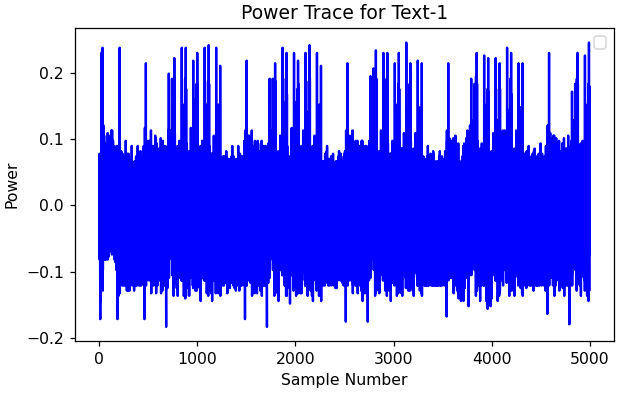

In [30]:
%matplotlib notebook
import matplotlib.pylab as plt
plt.figure(figsize=(5.5, 3.5), constrained_layout=True)

plt.plot(trace_array[0], color="blue")

plt.title("Power Trace for Text-1")     
plt.xlabel("Sample Number")  # adds x-axis label
plt.ylabel("Power")          # adds y-axis label
plt.legend()

# saves the plot
plt.savefig("../Figures/power_trace_text_1.pdf")

# show the plot on your screen
plt.show()

<IPython.core.display.Javascript object>


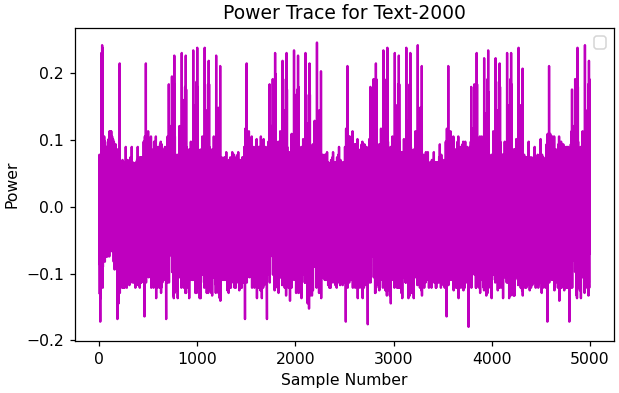

In [33]:
%matplotlib notebook
import matplotlib.pylab as plt
# raise NotImplementedError("Add your code here, and delete this.")
plt.figure(figsize=(5.5, 3.5), constrained_layout=True)

plt.plot(trace_array[2000], color="m")

plt.title("Power Trace for Text-2000")     
plt.xlabel("Sample Number")  # adds x-axis label
plt.ylabel("Power")          # adds y-axis label
plt.legend()

# saves the plot
plt.savefig("../Figures/power_trace_text_2000.pdf")

# show the plot on your screen
plt.show()

OK interesting - so we've got data! And what about the format of the input data?

In [34]:
print(textin_array[0])
print(textin_array[1])

CWbytearray(b'4e 16 a7 13 fe 43 11 d9 59 42 9c 8c 5c ac 0a 00')
CWbytearray(b'ea 4f ee 79 a7 56 de 1b c4 01 2a 09 e8 90 c1 c9')


In [35]:
print(trace_array[0])

[ 0.05859375  0.078125   -0.046875   ...  0.1796875  -0.07421875
  0.09765625]


## AES Guesser - One Byte

The attack now needs a way of splitting traces into two groups, depending on the state of a bit in our "guessed" value. We're going to start easy by guessing a single byte of the AES key at a time.

To start with - define the number of traces & number of points in each trace. You can use the following example code, just run this block:

In [36]:
numtraces = np.shape(trace_array)[0] #total number of traces
numpoints = np.shape(trace_array)[1] #samples per trace

print(numtraces)
print(numpoints)
print(textin_array)

2500
5000
[CWbytearray(b'4e 16 a7 13 fe 43 11 d9 59 42 9c 8c 5c ac 0a 00'), CWbytearray(b'ea 4f ee 79 a7 56 de 1b c4 01 2a 09 e8 90 c1 c9'), CWbytearray(b'3a b6 f3 a3 ba d1 68 48 da 84 72 ba e7 dc 93 f1'), CWbytearray(b'fb b7 0b e3 db d8 b0 48 bd 6e bc 6a 57 fb d1 ae'), CWbytearray(b'56 77 44 65 e9 58 b8 ca 40 06 47 e4 57 0b b9 9b'), CWbytearray(b'31 a6 e2 42 ff 55 c0 c3 90 5f 76 84 cc 8d c8 5b'), CWbytearray(b'ff 13 bc 7a 43 a5 0c 3a 5b 42 93 12 19 5d 7b fb'), CWbytearray(b'20 cb a0 22 0a 52 f7 40 32 28 ea 45 7a 33 e6 cb'), CWbytearray(b'23 62 3b 31 23 30 f3 d5 e0 43 81 eb 1a 90 c9 ee'), CWbytearray(b'64 77 b1 d4 4a 0e 4b 71 42 bd c4 e1 5a b1 7d 22'), CWbytearray(b'de 35 5d ab cc 45 0d cb 20 df e9 fd a7 9f 87 e0'), CWbytearray(b'92 65 99 3f 6f 8d 92 83 6c 85 88 04 36 7e 70 e8'), CWbytearray(b'db 50 5c fb 79 c6 b9 5d 83 b9 e3 6f 22 c1 33 1a'), CWbytearray(b'3d 69 2e 33 6a 43 f7 58 08 20 aa c0 5f bc 76 90'), CWbytearray(b'00 2e 04 68 02 3f d8 37 eb 62 f0 e8 9d 2e 59 f0'), CWbytearray(b'

If you remember from the slides - our algorithm looks like this:    

    for key_byte_guess_value in [0, 1, 2, 3, ... 253, 254, 255]:
        
        one_list = empty list
        zero_list = empty list
        
        for trace_index in [0, 1, 2, 3, ..., numtraces]:
        
            input_byte = textin_array[trace_index][byte_to_attack]
            
            #Get a hypothetical leakage list - use aes_internal(guess, input_byte)          

            if hypothetical_leakage bit 0 is 1:
                append trace_array[trace_index] to one_list
            else:
                append trace_array[trace_index] to zero_list
                
        one_avg = average of one_list
        zero_avg = average of zero_list

        max_diff_value = maximum of ABS(one_avg - zero_avg)
        
To get the average of your `one_list` and `zero_list` you can use numpy:

    import numpy as np
    avg_one_list = np.asarray(one_list).mean(axis=0)

The important thing here is the `axis=0`, which does an average so the resulting array is done across all traces (not just the average value of one trace, but the average of each point index *across all traces*).

To help you do some testing - let me tell you that the correct value of byte 0 is `0x2B`. You can use this to validate that your solution is working on the first byte. If you get stuck - see some hints below (but give it a try first).

What you should see is an output of the maximum value between the two average groups be higher for the `0x2B` value. For example, priting the maximum SAD value from an example loop looks like this for me:

    Guessing 28: 0.001397
    Guessing 29: 0.000927
    Guessing 2a: 0.001953
    Guessing 2b: 0.005278
    Guessing 2c: 0.000919
    Guessing 2d: 0.002510
    Guessing 2e: 0.001241
    Guessing 2f: 0.001242

Note the value of `0.005278` for `0x2B` - this is higher than the others which range from `0.000927` to `0.002510`.

In [37]:
import numpy as np
mean_diffs = []

### Code to do guess of byte 0 set to 0x2B
guessed_byte = 0

for guess in range(0, 256):
    one_list = []
    zero_list = []

    for trace_index in range(numtraces):
        hypothetical_leakage = aes_internal(guess, textin_array[trace_index][guessed_byte])

        #Mask off the lowest bit - is it 0 or 1? Depending on that add trace to array
        if hypothetical_leakage & 0x01:        
            one_list.append(trace_array[trace_index])
        else:
            zero_list.append(trace_array[trace_index])

    one_avg = np.asarray(one_list).mean(axis=0)
    zero_avg = np.asarray(zero_list).mean(axis=0)
    mean_diffs_2b = np.max(abs(one_avg - zero_avg))
    mean_diffs.append(mean_diffs_2b)

    print("Max SAD for {:02X}: {:2}".format(guess,mean_diffs_2b))
    
print("max value is",max(mean_diffs),hex(mean_diffs.index(max(mean_diffs))))

Max SAD for 00: 0.0012697683308595456
Max SAD for 01: 0.0011153157138020509
Max SAD for 02: 0.001448541705071485
Max SAD for 03: 0.001376702724358983
Max SAD for 04: 0.0010664585602101484
Max SAD for 05: 0.0010555647204751085
Max SAD for 06: 0.0010374290988655818
Max SAD for 07: 0.0013291956220041756
Max SAD for 08: 0.001524391097850089
Max SAD for 09: 0.0013015458164768057
Max SAD for 0A: 0.0010894304952212691
Max SAD for 0B: 0.0014737956251202784
Max SAD for 0C: 0.0013794765033575684
Max SAD for 0D: 0.0011747930074700944
Max SAD for 0E: 0.0010260134736173113
Max SAD for 0F: 0.001135032905684244
Max SAD for 10: 0.00122247298385883
Max SAD for 11: 0.0019854770705325132
Max SAD for 12: 0.0012942611690894487
Max SAD for 13: 0.0013275543766272657
Max SAD for 14: 0.0012597861018871503
Max SAD for 15: 0.0016205094302525098
Max SAD for 16: 0.0012029929239241802
Max SAD for 17: 0.0013835279691211018
Max SAD for 18: 0.0011516771726970132
Max SAD for 19: 0.001918599561067394
Max SAD for 1A: 0.0

In [38]:
print("max value is",max(mean_diffs),hex(mean_diffs.index(max(mean_diffs))))
len(mean_diffs)
np.argsort(mean_diffs)

max value is 0.0035029950877583926 0x2b


array([236,  56, 131,  49, 237, 172, 166, 167,  60, 171, 120,  81, 241,
       160, 224, 200, 159, 238,  14,  88,  50,   6,  36,  62,  58,  40,
       192, 170, 106,  29,   5, 128, 240, 151,   4,  31,  69,  91,  72,
        10, 153,  46, 168, 161, 124, 144,  85, 113, 116, 165,  71,  87,
         1, 147,  77,  68,  74, 169,  96,  53, 254,  15, 203, 164, 209,
       193,  93,  39,  79,  24, 177, 234,  26, 202, 229,  48, 134, 218,
       205, 183,  13, 191, 135, 127, 186, 141,  92, 211, 198, 204, 252,
       100,  22,  32,  86, 249,  90, 122, 119, 228, 173, 137, 248,  16,
       104,  89, 112,  28,  34, 102,  47, 145, 157, 213, 195, 136, 139,
        82, 247, 242,  37, 187,  20,  61,  63, 251, 210, 154, 133,   0,
       220,  70,  66, 250,  51, 126, 163, 231,  18, 114,   9, 138, 142,
        54,  94, 143, 110, 129, 216,  59, 232,  19,  80,   7, 101, 221,
       149, 243, 253, 227, 219,  42, 208, 176, 201, 175,   3,  12, 239,
        45,  23, 196, 130, 125,  55,  38, 174, 162, 118, 197, 23

### Hint 1: General Program Flow

You can use the following general program flow to help you implement the outer loop above:

In [80]:
# #Hint #1 - General Program Flow
# import numpy as np
# mean_diffs = np.zeros(256)

# guessed_byte = 0

# for guess in range(0, 256):
    
#     one_list = []
#     zero_list = []
    
#     for trace_index in range(numtraces):
#         #Inside here do the steps shown above
#         pass
    
# # for i in range(len(trace_array)):
# #     if textin_array[i][0] == 0x00:
# #         one_list.append(trace_array[i])
        
# #     else:
# #         zero_list.append(trace_array[i])


# # assert len(one_list) > len(zero_list)/2
# # assert len(zero_list) > len(one_list)/2

# # print(len(one_list))
# # print(len(zero_list))
        
#     #Do extra steps to average one_list and zero_list        

### Hint 2: Example of Two Different Key Guesses

We aren't fully going to give it away, but here is how you can generate two differences, for `0x2B` and `0xFF`. If you're totally stuck you can use the following code to base what should be inside the loops on.

In [ ]:
# import numpy as np
# mean_diffs = np.zeros(256)

# ### Code to do guess of byte 0 set to 0x2B
# guessed_byte = 0
# guess = 0x2B
   
# one_list = []
# zero_list = []
    
# for trace_index in range(numtraces):
#     hypothetical_leakage = aes_internal(guess, textin_array[trace_index][guessed_byte])

#     #Mask off the lowest bit - is it 0 or 1? Depending on that add trace to array
#     if hypothetical_leakage & 0x01:        
#         one_list.append(trace_array[trace_index])
#     else:
#         zero_list.append(trace_array[trace_index])
            
# one_avg = np.asarray(one_list).mean(axis=0)
# zero_avg = np.asarray(zero_list).mean(axis=0)
# mean_diffs_2b = np.max(abs(one_avg - zero_avg))

# print("Max SAD for 0x2B: {:1}".format(mean_diffs_2b))

# ### Code to do guess of byte 0 set to 0xFF
# guessed_byte = 1
# guess = 0xFF
    
# one_list = []
# zero_list = []
    
# for trace_index in range(numtraces):
#     hypothetical_leakage = aes_internal(guess, textin_array[trace_index][guessed_byte])

#     #Mask off the lowest bit - is it 0 or 1? Depending on that add trace to array
#     if hypothetical_leakage & 0x01:        
#         one_list.append(trace_array[trace_index])
#     else:
#         zero_list.append(trace_array[trace_index])
            
# one_avg = np.asarray(one_list).mean(axis=0)
# zero_avg = np.asarray(zero_list).mean(axis=0)
# mean_diffs_ff = np.max(abs(one_avg - zero_avg))

# print("Max SAD for 0xFF: {:1}".format(mean_diffs_ff))

## Ranking Guesses

You'll also want to rank some of your guesses (we assume). This will help you identify the most likely value. The best way to do this is build a list of the maximum difference values for each key:

    mean_diffs = [0]*256

    for key_byte_guess_value in [0, 1, 2, 3, ... 253, 254, 255]:

        *** CODE FROM BEFORE***
        max_diff_value = maximum of ABS(one_avg - zero_avg)
        mean_diffs[key_byte_guess_value] = max_diff_value
        
If you modify your previous code, it will generate a list of maximum differences in a list. This list will look like:

    [0.002921, 0.001923, 0.005131, ..., 0.000984]
    
Where the *index* of the list is the value of the key guess. We can use `np.argsort` which generates a new list showing the *indicies* that would sort an original list (you should have learned about `argsort` in the previous lab too):

So for example, run the following to see it in action on the list `[1.0, 0.2, 3.4, 0.01]`:

In [39]:
np.argsort([1.0, 0.2, 3.4, 0.01])

array([3, 1, 0, 2])

This should return `[3, 1, 0, 2`] - that is the order of lowest to highest. To change from highest to lowest, remember you just add `[::-1]` at the end of it like `np.argsort([1.0, 0.2, 3.4, 0.01])[::-1]`.

Try using the `np.argsort` function to output the most likely key values from your attack.

## Plotting Differences

Before we move on - you should take a look at various plots of these differences. They will play in something called the *ghost peak* problem.

We're going to now define a function called `calculate_diffs()` that implements our attacks (you can replace this with your own function or keep this one for now):

In [40]:
def calculate_diffs(guess, byteindex=0, bitnum=0):
    """Perform a simple DPA on two traces, uses global `textin_array` and `trace_array` """
    
    one_list = []
    zero_list = []

    for trace_index in range(numtraces):
        hypothetical_leakage = aes_internal(guess, textin_array[trace_index][byteindex])

        #Mask off the requested bit
        if hypothetical_leakage & (1<<bitnum):
            one_list.append(trace_array[trace_index])
        else:
            zero_list.append(trace_array[trace_index])

    one_avg = np.asarray(one_list).mean(axis=0)
    zero_avg = np.asarray(zero_list).mean(axis=0)
    return abs(one_avg - zero_avg)

Try plotting the difference between various bytes. For byte 0, remember `0x2B` is the correct value. Zoom in on the plots and see how the correct key should have a much larger difference.

Sometimes we get *ghost peaks* which are incorrect peaks. So far we're assuming there is a single "best" solution for the key - we may need to get fancy and put a threshold whereby we have several candidates for the correct key. For now let's just plot a handful of examples:

<IPython.core.display.Javascript object>


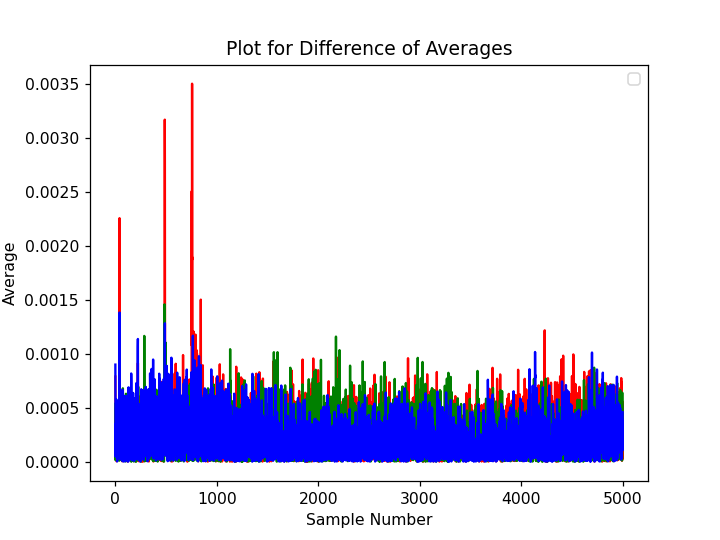

In [43]:
%matplotlib notebook
import matplotlib.pylab as plt
known_key = [0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]

plt.title("Plot for Difference of Averages")     
plt.xlabel("Sample Number")  # adds x-axis label
plt.ylabel("Average")          # adds y-axis label
plt.legend()

plt.plot(calculate_diffs(0x2B), 'r')
plt.plot(calculate_diffs(0x2C), 'g')
plt.plot(calculate_diffs(0x2D), 'b')
plt.savefig("../Figures/calculate_diffs.pdf")
plt.show()

When we rank the bytes, we just use the maximum value of any peak. There is a lot more you could learn from these graphs, such as the location of the peak, or if there are multiple peaks in the graph.

## AES Guesser - All Bytes

Alright - good job! You've got a single byte and some DPA plots up. Now let's move onward and guess *all* of the bytes.

Doing this requires a little more effort than before. Taking your existing guessing function, you're going to wrap a larger loop around the outside of it like this:

    for subkey in range(0,16):
        #Rest of code from before!
        

In [44]:
from tqdm import tnrange
import numpy as np

#Store your key_guess here, compare to known_key
key_guess = []
known_key = [0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]

### Code to do guess of byte 0 set to 0x2B
guessed_byte = 0
for subkey in tnrange(0, 16, desc="Attacking Subkey"):
    mean_diffs = []
    for guess in range(0, 256):
        one_list = []
        zero_list = []

        for trace_index in range(numtraces):
            hypothetical_leakage = aes_internal(guess, textin_array[trace_index][subkey])

            #Mask off the lowest bit - is it 0 or 1? Depending on that add trace to array
            if hypothetical_leakage & 0x01:        
                one_list.append(trace_array[trace_index])
            else:
                zero_list.append(trace_array[trace_index])

        one_avg = np.asarray(one_list).mean(axis=0)
        zero_avg = np.asarray(zero_list).mean(axis=0)
        mean_diffs_2b = np.max(abs(one_avg - zero_avg))
        mean_diffs.append(mean_diffs_2b)

    key_guess.append(hex(mean_diffs.index(max(mean_diffs))))
    print("max value is",max(mean_diffs),'sub key', (subkey+1),'is',hex(mean_diffs.index(max(mean_diffs))))

/tmp/ipykernel_2832/795905765.py:10: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for subkey in tnrange(0, 16, desc="Attacking Subkey"):


Attacking Subkey:   0%|          | 0/16 [00:00<?, ?it/s]

max value is 0.0035029950877583926 sub key 1 is 0x2b
max value is 0.003996273045899751 sub key 2 is 0x7e
max value is 0.0037052342149077877 sub key 3 is 0x15
max value is 0.0034250350723591394 sub key 4 is 0x16
max value is 0.0034087634918104973 sub key 5 is 0x28
max value is 0.0038835811130348424 sub key 6 is 0xae
max value is 0.003348300043029606 sub key 7 is 0xd2
max value is 0.004007108094262302 sub key 8 is 0xa6
max value is 0.0038892546605710024 sub key 9 is 0xab
max value is 0.0032982766645475448 sub key 10 is 0xf7
max value is 0.003599834900627999 sub key 11 is 0x15
max value is 0.0039112808242502475 sub key 12 is 0x88
max value is 0.0033271862602003155 sub key 13 is 0x9
max value is 0.0038159920255892987 sub key 14 is 0xcf
max value is 0.0036928257443463453 sub key 15 is 0x4f
max value is 0.0033206865469204497 sub key 16 is 0x3c


In [88]:
print(key_guess)

['0x2b', '0x7e', '0x15', '0x16', '0x28', '0xae', '0xd2', '0xa6', '0xab', '0xf7', '0x15', '0x88', '0x9', '0xcf', '0x4f', '0x3c']


🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳
Congrats - you did it!!!!

Hopefully the above worked - but we're going to go a little further to understand how to apply this in case it didn't work right away (or it almost worked).

## Ghost Peaks

Maybe the previous didn't actually recover the full key? No need to worry - there are a few reasons for this. One artifact of a DPA attack is you get another strong peak that isn't the correct key (which can be a ghost peak).

We're going to get into more efficient attacks later, but for now, let's look at some solutions:

* Increase the number of traces recorded.
* Change the targetted bit (& combine solutions from multiple bits).
* Window the input data.

The first one is the brute-force option: go from 2500 to 5000 or even 10000 power traces. As you add more data, you may find the problem is reduced. But real ghost peaks may not disappear, so we need to move onto other solutions.

Before we begin - we're going to give you a "known good" DPA attack script we're going to build on. This uses the `calculate_diffs()` function defined earlier.

Run the following block (will take a bit of time):

In [45]:
from tqdm import tnrange
import numpy as np

#Store your key_guess here, compare to known_key
key_guess = []
known_key = [0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]

#Which bit to target
bitnum = 0

full_diffs_list = []

for subkey in tnrange(0, 16, desc="Attacking Subkey"):
    
    max_diffs = [0]*256
    full_diffs = [0]*256

    for guess in range(0, 256):
        full_diff_trace = calculate_diffs(guess, subkey, bitnum)
        max_diffs[guess] = np.max(full_diff_trace)
        full_diffs[guess] = full_diff_trace
    
    #Make copy of the list
    full_diffs_list.append(full_diffs[:])
    
    #Get argument sort, as each index is the actual key guess.
    sorted_args = np.argsort(max_diffs)[::-1]
    
    #Keep most likely
    key_guess.append(sorted_args[0])
    
    #Print results
    print("Subkey %2d - most likely %02X (actual %02X)"%(subkey, key_guess[subkey], known_key[subkey]))
    
    #Print other top guesses
    print(" Top 5 guesses: ")
    for i in range(0, 5):
        g = sorted_args[i]
        print("   %02X - Diff = %f"%(g, max_diffs[g]))
    
    print("\n")

/tmp/ipykernel_2832/1918268658.py:13: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for subkey in tnrange(0, 16, desc="Attacking Subkey"):


Attacking Subkey:   0%|          | 0/16 [00:00<?, ?it/s]

Subkey  0 - most likely 2B (actual 2B)
 Top 5 guesses: 
   2B - Diff = 0.003503
   96 - Diff = 0.002695
   69 - Diff = 0.002568
   94 - Diff = 0.002553
   D6 - Diff = 0.002412


Subkey  1 - most likely 7E (actual 7E)
 Top 5 guesses: 
   7E - Diff = 0.003996
   D5 - Diff = 0.002411
   3C - Diff = 0.002346
   40 - Diff = 0.002281
   63 - Diff = 0.002278


Subkey  2 - most likely 15 (actual 15)
 Top 5 guesses: 
   15 - Diff = 0.003705
   63 - Diff = 0.002561
   6B - Diff = 0.002399
   D6 - Diff = 0.002362
   94 - Diff = 0.002129


Subkey  3 - most likely 16 (actual 16)
 Top 5 guesses: 
   16 - Diff = 0.003425
   28 - Diff = 0.002485
   82 - Diff = 0.002383
   69 - Diff = 0.002379
   2B - Diff = 0.002348


Subkey  4 - most likely 28 (actual 28)
 Top 5 guesses: 
   28 - Diff = 0.003409
   6F - Diff = 0.002590
   61 - Diff = 0.002549
   9C - Diff = 0.002504
   94 - Diff = 0.002465


Subkey  5 - most likely AE (actual AE)
 Top 5 guesses: 
   AE - Diff = 0.003884
   6B - Diff = 0.002409
   13 

This block should now print some *next top guesses* - in this case just the next top 5 guesses, but you can extend this if you wish. It's also keeping a copy of all the *difference* traces (unlike before where it threw them away).

### Plotting Peaks

After it runs, select a subkey that is either wrong or has very close "next best guesses". For example, the following shows the output for Subkey 5 is actually wrong - the correct guess (`0xAE`) has been ranked as option 5.

    Subkey  5 - most likely CB (actual AE)
     Top 5 guesses: 
       CB - Diff = 0.003006
       C5 - Diff = 0.002984
       AE - Diff = 0.002739
       3C - Diff = 0.002674
       2F - Diff = 0.002511

You can find the full diff in the `full_diffs_list` array. If you index this array it will give you every guess for a given subkey (for example `full_diffs_list[5]` is the 5th subkey guess outputs).

Using `full_diffs_list[N]` to get your selected subkey, plot the correct key by plotting `full_diffs_list[N][0xCORRECT]` in green as the *last* (so it appears on top). Plot a few other highly ranked guesses before that. In my example, this would look like:

    %matplotlib notebook
    import matplotlib.pylab as plt

    plt.plot(full_diffs_list[5][0xC5], 'r')
    plt.plot(full_diffs_list[5][0xCB], 'r')
    plt.plot(full_diffs_list[5][0xAE], 'g')

<IPython.core.display.Javascript object>


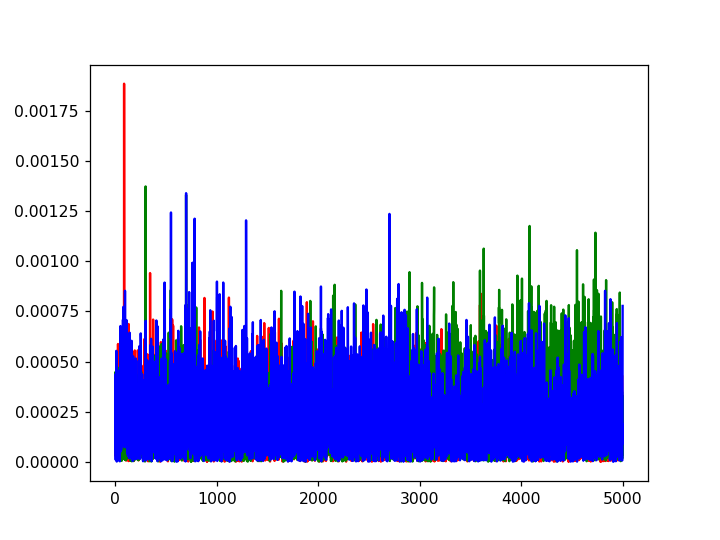

In [46]:
%matplotlib notebook
import matplotlib.pylab as plt

plt.plot(full_diffs_list[5][0x2B], 'r')
plt.plot(full_diffs_list[5][0x1E], 'g')
plt.plot(full_diffs_list[5][0x7E], 'b')

Zoom in on the window, and you should notice there is a location where the correct peak is *higher* than the incorrect peaks. If you want to plot all the traces (this will get slow!) for a given trace, we can do so as the following:

<IPython.core.display.Javascript object>


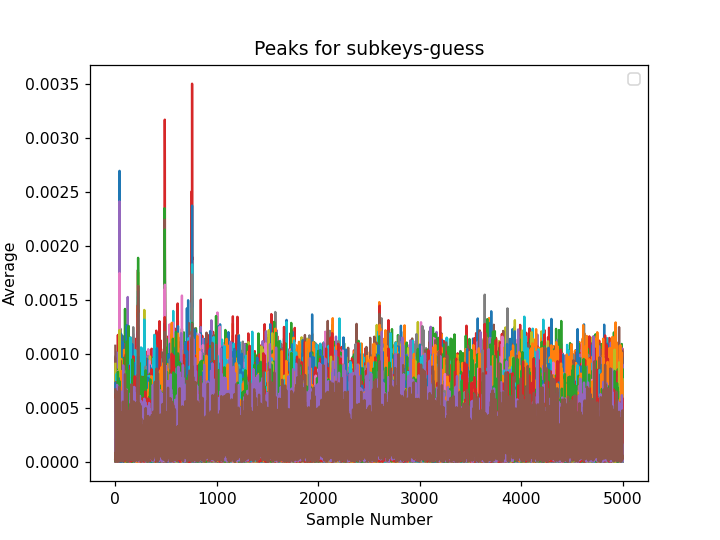

In [48]:
plt.figure()
subkey = 0
for guess in range(0, 256):
    plt.plot(full_diffs_list[subkey][guess])
    
plt.title("Peaks for subkeys-guess")     
plt.xlabel("Sample Number")  # adds x-axis label
plt.ylabel("Average")          # adds y-axis label
plt.legend()

plt.savefig("../Figures/plotting_peaks_1.pdf")
plt.show()

Depending on your hardware, the previous may show a single nice large spike, or multiple large spikes. If we have the ghost peak problem you've probably got multiple spikes. The incorrect peaks may trail behind the correct locations -- we can first plot the correct locations by looking at the known key. The following will do that:

<IPython.core.display.Javascript object>


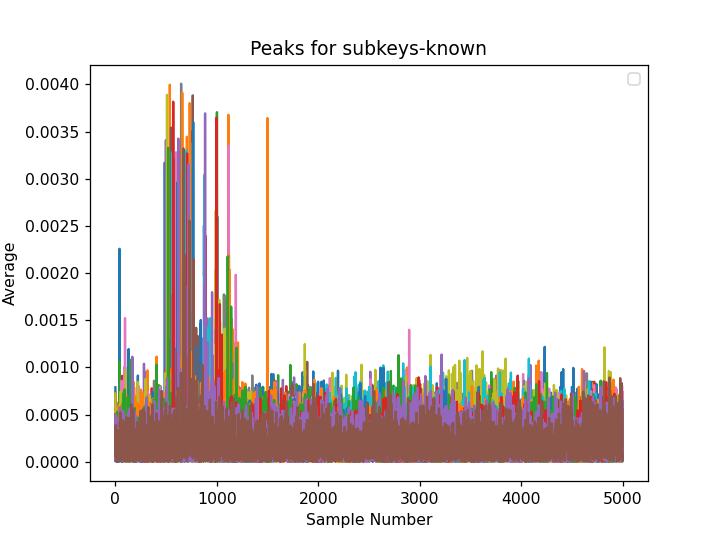

In [50]:
plt.figure()
for subkey in range(0, 16):
    plt.plot(full_diffs_list[subkey][known_key[subkey]])
    
plt.title("Peaks for subkeys-known")     
plt.xlabel("Sample Number")  # adds x-axis label
plt.ylabel("Average")          # adds y-axis label
plt.legend()

plt.savefig("../Figures/plotting_peaks_2.pdf")
plt.show()

### Windowing Peaks

The final trick here - see if there is some way to "window" the data that could be useful. For example, looking at the peaks you might notice that the correct peaks are always coming at 60 cycle offsets, with the first peak around sample 1100 (these will be different for your hardware).

So we could modify the loop to only look at differences after this point:

    for guess in range(0, 256):
        full_diff_trace = calculate_diffs(guess, subkey, bitnum)
        full_diff_trace = full_diff_trace[(1010 + subkey*60):]
        max_diffs[guess] = np.max(full_diff_trace)
        full_diffs[guess] = full_diff_trace
        
Copy the full DPA attack here - and try it out! See if you can get the correct key to come out for every byte.

In [117]:
from tqdm import tnrange
import numpy as np

#Store your key_guess here, compare to known_key
key_guess = []
known_key = [0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]

#Which bit to target
bitnum = 0

full_diffs_list = []

for subkey in tnrange(0, 16, desc="Attacking Subkey"):

    max_diffs = [0]*256
    full_diffs = [0]*256

    for guess in range(0, 256):
        full_diff_trace = calculate_diffs(guess, subkey, bitnum)
        full_diff_trace = full_diff_trace[(0 + subkey*0):]
        max_diffs[guess] = np.max(full_diff_trace)
        full_diffs[guess] = full_diff_trace

    #Make copy of the list
    full_diffs_list.append(full_diffs[:])

    #Get argument sort, as each index is the actual key guess.
    sorted_args = np.argsort(max_diffs)[::-1]

    #Keep most likely
    key_guess.append(sorted_args[0])

    #Print results
    print("Subkey %2d - most likely %02X (actual %02X)"%(subkey, key_guess[subkey], known_key[subkey]))

    #Print other top guesses
    print(" Top 5 guesses: ")
    for i in range(0, 5):
        g = sorted_args[i]
        print("   %02X - Diff = %f"%(g, max_diffs[g]))

    print("\n")

/tmp/ipykernel_3168/1681731736.py:13: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for subkey in tnrange(0, 16, desc="Attacking Subkey"):


Attacking Subkey:   0%|          | 0/16 [00:00<?, ?it/s]

Subkey  0 - most likely 2B (actual 2B)
 Top 5 guesses: 
   2B - Diff = 0.006800
   6B - Diff = 0.005982
   96 - Diff = 0.005277
   9C - Diff = 0.004950
   63 - Diff = 0.004811


Subkey  1 - most likely 7E (actual 7E)
 Top 5 guesses: 
   7E - Diff = 0.007776
   9E - Diff = 0.005319
   EC - Diff = 0.005000
   9C - Diff = 0.004550
   B4 - Diff = 0.004488


Subkey  2 - most likely 15 (actual 15)
 Top 5 guesses: 
   15 - Diff = 0.007945
   8C - Diff = 0.005493
   96 - Diff = 0.005429
   6B - Diff = 0.005243
   63 - Diff = 0.005130


Subkey  3 - most likely 16 (actual 16)
 Top 5 guesses: 
   16 - Diff = 0.008146
   7D - Diff = 0.005596
   84 - Diff = 0.004852
   6A - Diff = 0.004609
   8F - Diff = 0.004589


Subkey  4 - most likely 28 (actual 28)
 Top 5 guesses: 
   28 - Diff = 0.008695
   6F - Diff = 0.005800
   90 - Diff = 0.005375
   98 - Diff = 0.004971
   6B - Diff = 0.004807


Subkey  5 - most likely AE (actual AE)
 Top 5 guesses: 
   AE - Diff = 0.007960
   96 - Diff = 0.004787
   B1 

## Conclusions & Next Steps

You've now seen how a DPA attack be be performed using a basic Python script. We'll experience much more effective attacks once we look at the CPA attack.

If you want to perform these attacks in practice, the Python code here isn't the most efficient! We'll look at faster options in later courses.

---
<small>NO-FUN DISCLAIMER: This material is Copyright (C) NewAE Technology Inc., 2015-2020. ChipWhisperer is a trademark of NewAE Technology Inc., claimed in all jurisdictions, and registered in at least the United States of America, European Union, and Peoples Republic of China.

Tutorials derived from our open-source work must be released under the associated open-source license, and notice of the source must be *clearly displayed*. Only original copyright holders may license or authorize other distribution - while NewAE Technology Inc. holds the copyright for many tutorials, the github repository includes community contributions which we cannot license under special terms and **must** be maintained as an open-source release. Please contact us for special permissions (where possible).

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</small>

In [61]:
scope.dis()
target.dis()